# Exploring the Crono MA-XRF HDF5 file format

Recently my lab, the Rijkserfgoedlaboratorium in Amsterdam, acquired a new Bruker Crono MA-XRF scanner. The instrument saves the spectral data into a specific Hierarchical Data File format (.HDF5). In order to make use of the data we needed to understand the file format. In this Jupyter notebook I report on a first attempt to read test data for ink drawings on paper using standard python libraries. 

The HDF5 file format is an open self documentable data container file format. It contains Groups and Datasets that can be understood as (sub)folders and files. An excellent python package that can be used to explore and read the contents of an hdf5 file is [h5py](https://docs.h5py.org/en/stable/index.html) by Andrew Collette. If you want to read more, the book by Andrew Collette *Python and HDF5 - Unlocking scientific data*, is an excellent introduction.  

I have installed `h5py` on my computer, so let's use it peek inside our crono datasets...

In [2]:
cd /home/frank/Work/Projecten/DoRe/data/maxrf/crono 

/mnt/datadisk/Work/Projecten/DoRe/data/maxrf/crono


As a first step we need to open the crono hdf5 file for reading. Let's start with the smallest file (50 Mb): 

In [3]:
import h5py 

crono_filename = '14200215102021-blindTest2AgedDetail.HDF5' # 50 Mb 
fh = h5py.File(crono_filename, mode='r')

groups_and_datasets = []
fh.visit(groups_and_datasets.append) 

datasets = [fh[d] for d in groups_and_datasets if (type(fh[d]) == h5py.Dataset)]

And print the name and content of each dataset in our Crono HDF5 test file:

In [4]:
for i, d in enumerate(datasets): 
    print(f'({i}) {d.name}')
    print(f'     {d}')

(0) /Configuration/FinalSystemStatus
     <HDF5 dataset "FinalSystemStatus": shape (1,), type "|O">
(1) /Configuration/InitialSystemStatus
     <HDF5 dataset "InitialSystemStatus": shape (1,), type "|O">
(2) /Configuration/Settings
     <HDF5 dataset "Settings": shape (1,), type "|O">
(3) /CreatedDateTime
     <HDF5 dataset "CreatedDateTime": shape (50,), type "|S1">
(4) /CreatedWithSoftwareVersion
     <HDF5 dataset "CreatedWithSoftwareVersion": shape (50,), type "|S1">
(5) /FileStructureVersion
     <HDF5 dataset "FileStructureVersion": shape (2,), type "<i4">
(6) /Images/Documentation
     <HDF5 dataset "Documentation": shape (1,), type "|O">
(7) /Images/ImageAdjusting/ImagePixelSizeRatio
     <HDF5 dataset "ImagePixelSizeRatio": shape (1, 2), type "<f4">
(8) /Images/Static
     <HDF5 dataset "Static": shape (13358,), type "|O">
(9) /Images/StitchedImage
     <HDF5 dataset "StitchedImage": shape (1,), type "|O">
(10) /Images/VideoStreams
     <HDF5 dataset "VideoStreams": shape (1,)

Ok, most of these datasets have well defined data types, so it will be no problem to read them as we go along. As an example `"<f8"` means a *little-endian 8 byte float*. Unfortunately, I do not know how to read `"|O"` yet, so we need to ignore these datasets for now. Let's see if we can ask Bruker. 

As a starter let's take a look at the `CreatedDateTime`. With some tricks we can actually read the time string. Now it becomes clear why we see that funny number in the filename!

In [5]:
date_time = ''.join(datasets[3][()].astype(str))
print(f'The time stamp is: {date_time}')
print(f'The filename is: {crono_filename}')

The time stamp is: 10/15/2021 14:20:02
The filename is: 14200215102021-blindTest2AgedDetail.HDF5


The total number of measured spectra present in the data can be found as follows.

In [6]:
spectra = fh['/XRF/Spectra']
n_spectra, n_channels = spectra.shape
print(f'The data contains {n_spectra} spectra, and each spectrum contains {n_channels} energy channels.')

The data contains 4284 spectra, and each spectrum contains 4096 energy channels.


Only a part of the measured spectra is actually used to create the spectral image cube. Have a look at xy-stage motors positions and the index of selected spectra. 

In [7]:
motors_positions = fh['/XRF/MotorsPositions'][()]
x, y, z = motors_positions.T

spectra_selected_index = fh['/XRF/SpectraSelectedIndex'][()]
spectra_indices = spectra_selected_index.flatten() # useful for plotting

height, width, _ = spectra_selected_index.shape 
n_sel_spectra = height * width
print(f'The (selected) spectral image cube has a height x width of {height} x {width} pixels = {n_sel_spectra} spectra.')

The (selected) spectral image cube has a height x width of 85 x 37 pixels = 3145 spectra.


One would expect to find a rectangular array of sensor positions. Now let's plot the *(x, y)* positions of all 3145 measured spectra (blue) and see which positions have been selected by the Crono software. 

Text(0.5, 1.0, 'Selected spectra \n14200215102021-blindTest2AgedDetail.HDF5')

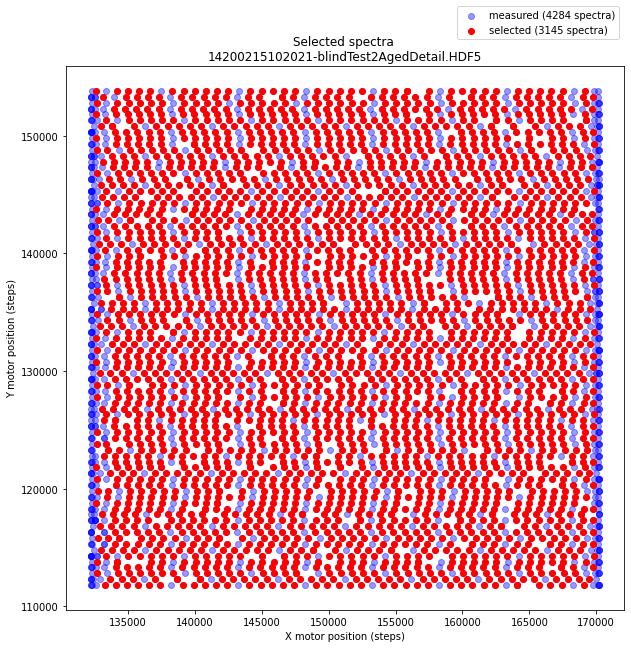

In [8]:
import matplotlib.pyplot as plt 
import numpy as np 

fig, ax = plt.subplots(figsize=[10, 10])
ax.scatter(x, y, c='b', alpha=0.4, label=f'measured ({n_spectra} spectra)')
ax.scatter(x[spectra_indices], y[spectra_indices], color='r', label=f'selected ({n_sel_spectra} spectra)')
ax.set_xlabel('X motor position (steps)')
ax.set_ylabel('Y motor position (steps)')
ax.legend(bbox_to_anchor=(1,1.04), loc="lower right")
ax.set_title(f'Selected spectra \n{crono_filename}')

Mm, the xy positions of the sensor are a bit wobbly. We observe 85 rows of selected (*y*) positions. In each row we count 37 selected spectra (red dots). If we ignore any possible problems due to the irregularity we can simply compose the 85 x 37 x 4096 spectral image cube from the selected spectra.  

Although our tiny test data files fit well into memory, typical MA-XRF data files can be rather big. In order to be ready for these big files I will show below how do efficient out of memory computations that read and write directly from and to disk. 

In [9]:
# python package for reading hdf5 files 
import h5py 

# python package for processing too-big-for-memory data 
import dask 
import dask.array as da 
import dask_ndfilters 
from dask.diagnostics import ProgressBar 

# python package for a new data container file format called z-arrays
import zarr 

# array computions 
import numpy as np 

# regular expressions
import re 

# plotting and printing 
import matplotlib.pyplot as plt 
from IPython.display import HTML 

# standard datapath locations for zarr zipstore 
MAXRF_CUBE = 'maxrf_cube'
MAXRF_MAX_SPECTRUM = 'maxrf_max_spectrum'
MAXRF_SUM_SPECTRUM = 'maxrf_sum_spectrum'
MAXRF_ENERGIES = 'maxrf_energies'


# FUNCTION TO READ AND CONVERT CRONO HDF5 FILE 

def convert_crono(crono_filename): 
    '''Read spectral data from Crono maxrf hdf5 file and convert to zarr zipstore format.
    
    Compose (smoothed) spectral image data cube from selected spectra. Furthermore, 
    calculate smoothed sum and max spectra. '''
    
    
    with h5py.File(crono_filename, mode='r') as fh: 

        # STEP 1: SCHEDULE COMPUTIONS WITH (LAZY) DASK ARRAYS 

        # read spectral data cube from hdf5 dataset into dask array 
        dataset = fh['/XRF/Spectra']
        arr = da.from_array(dataset) 
        arr = arr.astype(np.float32)

        # schedule spectral dimension gaussian smoothing computation 
        spectra_arr = dask_ndfilters.gaussian_filter(arr, (0, 7))

        n_spectra, n_channels = spectra_arr.shape  

        # READ SCAN POSITIONS AND SHUFFLE SPECTRA INTO CUBE 

        # read and convert position indices to numpy array and remove inner bracket 
        spectra_indices = fh['/XRF/SpectraSelectedIndex'][:,:,0]

        # spectral image height and width  
        h, w = spectra_indices.shape 

        # flatten indices table into list
        spectra_indices = spectra_indices.flatten()

        # shuffle spectrum positions according to indices 
        cube_arr = spectra_arr[spectra_indices].reshape([h, w, n_channels]) 

        # read energy (keV) calibration values of channels  
        energy_vector = fh['/XRF/EnergyVector'][:] 
        # find channel index of our favorite element iron 
        FeKa_i = np.argmin((energy_vector - 6.402)**2)

        # STEP 2: EXECUTE DASK ARRAY COMPUTIONS AND WRITE TO ZIPSTORE 
             
        # create/overwrite and open an empty zarr zipstore file for writing 
        zs_filename = re.sub('\.[^.]*$', '.zipstore', crono_filename) 
        zs = zarr.ZipStore(zs_filename, mode='w') 

        # compute and write maxrf data to datapath in zipstore 
        
        print('Computing (smoothed) spectral data cube...')
        with ProgressBar(): 
            cube_arr.to_zarr(zs, component=MAXRF_CUBE)  
            
        print('Computing (smoothed) max spectrum...')
        with ProgressBar(): 
            (cube_arr.reshape([h*w, n_channels])).max(axis=0).to_zarr(zs, component=MAXRF_MAX_SPECTRUM)

        print('Computing (smoothed) sum spectrum...')
        with ProgressBar():
            ((cube_arr.reshape([h*w, n_channels])).sum(axis=0) / (h*w) ).to_zarr(zs, component=MAXRF_SUM_SPECTRUM)
        
        print('Writing channel energies...')
        with ProgressBar(): 
            da.from_array(energy_vector).to_zarr(zs, component=MAXRF_ENERGIES)
            
        zs.close()
            
        return zs_filename 


# FUNCTIONS FOR USING ZARR ZIPSTORE FILES 
    
def tree(zs_filename, show_arrays=False): 
    '''Prints content tree of *zipstore_file*'''

    with zarr.ZipStore(zs_filename, mode='r') as zs: 
        root = zarr.group(store=zs) 
        tree = root.tree(expand=True).__repr__()
        print(f'\n{zs_filename}:\n\n{tree}')  
        
        if show_arrays:        
            datasets = sorted(root)
            arrays_html = ''

            for ds in datasets: 
                arr = da.from_array(root[ds])
                html = arr._repr_html_()
                arrays_html = f'{arrays_html}- Dataset: <h style="color:brown">{ds}</h>{html}' 
   
            return HTML(arrays_html)


def get_array(zipstore_filename, datapath, compute=True): 
    '''Open zipstore *zipstore_filename* and return dataset from *datapath*. 
    
    For large files that do not fit into memory it is advised to set option compute=False. '''
    
    # open existing zipstore filehandle 
    zs = zarr.ZipStore(zipstore_filename, mode='r') 
    root = zarr.group(store=zs)
    
    # initialize dask array 
    arr = da.from_array(root[datapath])
    
    # return numpy array and close, 
    # otherwise return dask array and do not close  
    if compute: 
        arr = arr.compute()
        zs.close()
        
    return arr 

Ok, let's read and convert the Crono HDF5 file to a zipstore file format and inspect it's content tree. 

In [10]:
zs_filename = convert_crono('14200215102021-blindTest2AgedDetail.HDF5')

tree(zs_filename)

Computing (smoothed) spectral data cube...
[########################################] | 100% Completed |  0.7s
Computing (smoothed) max spectrum...
[########################################] | 100% Completed |  0.7s
Computing (smoothed) sum spectrum...
[########################################] | 100% Completed |  0.7s
Writing channel energies...
[########################################] | 100% Completed |  0.1s

14200215102021-blindTest2AgedDetail.zipstore:

/
 ├── maxrf_cube (85, 37, 4096) float32
 ├── maxrf_energies (4096,) float32
 ├── maxrf_max_spectrum (4096,) float32
 └── maxrf_sum_spectrum (4096,) float32


Now read the computed spectral image data from the newly created zipstore file. 

In [11]:
cube = get_array(zs_filename, 'maxrf_cube')
energies = get_array(zs_filename, 'maxrf_energies')
max_spectrum = get_array(zs_filename, 'maxrf_max_spectrum')
sum_spectrum = get_array(zs_filename, 'maxrf_sum_spectrum')

In [12]:
%matplotlib notebook

In [13]:
is_iron_Ka_band = (energies > 6.1) * (energies < 6.7) 

<IPython.core.display.Javascript object>


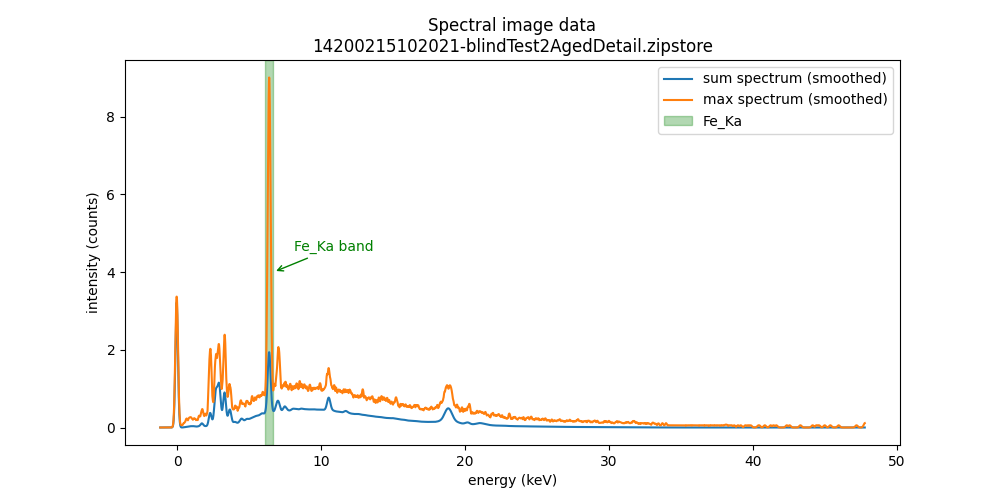

In [14]:
fig, ax = plt.subplots(figsize=[10, 5])

ax.plot(energies, sum_spectrum, label='sum spectrum (smoothed)')
ax.plot(energies, max_spectrum, label='max spectrum (smoothed)')

ax.set_xlabel('energy (keV)')
ax.set_ylabel('intensity (counts)')
ax.fill_between(energies, 0, 1, where=is_iron_Ka_band,
                color='green', alpha=0.3, transform=ax.get_xaxis_transform(), label='Fe_Ka')
ax.annotate('Fe_Ka band', xy=(6.7, 4),  xytext=(15, 15), textcoords='offset points', color='green', 
            arrowprops=dict(arrowstyle="->", color='green'))

ax.set_title(f'Spectral image data\n{zs_filename}')

ax.legend()

The further interpretation of the spectral data cube requires an understanding of the XRF physics involved and is outside the scope of this notebook. I close this notebook with an elemental distribution map calculated by integration of the iron *Fe_Ka* band.  

In [29]:
FeKa_slice = cube[:,:,is_iron_Ka_band]
FeKa_map = FeKa_slice.sum(axis=2) / 50 # number of channels in the Fe_Ka band 

# rotate and flipflop 
FeKa_map = FeKa_map.T[::-1, ::-1]

<IPython.core.display.Javascript object>


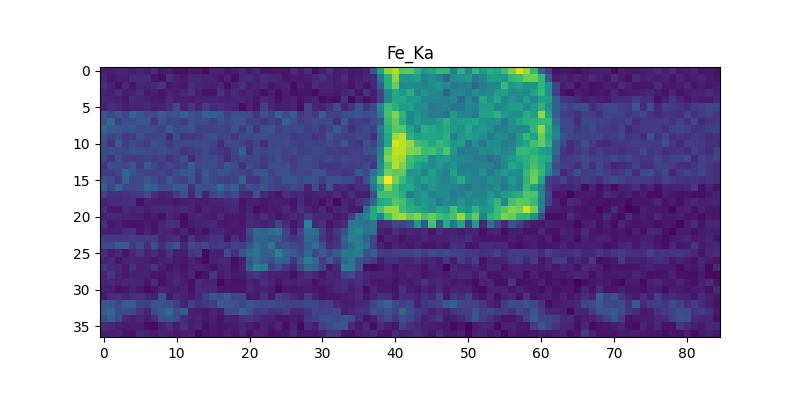

In [31]:
fig, ax = plt.subplots(figsize=[8, 4])
ax.imshow(FeKa_map)
ax.set_title('Fe_Ka');

And here is the side by side comparison with area in our paper sample.  

In [46]:
img_vis = plt.imread('Ink-08-aged-VIS.png')[100:1200, 100:1300] # roughly the scanning area
h, w, _ = img_vis.shape

<IPython.core.display.Javascript object>


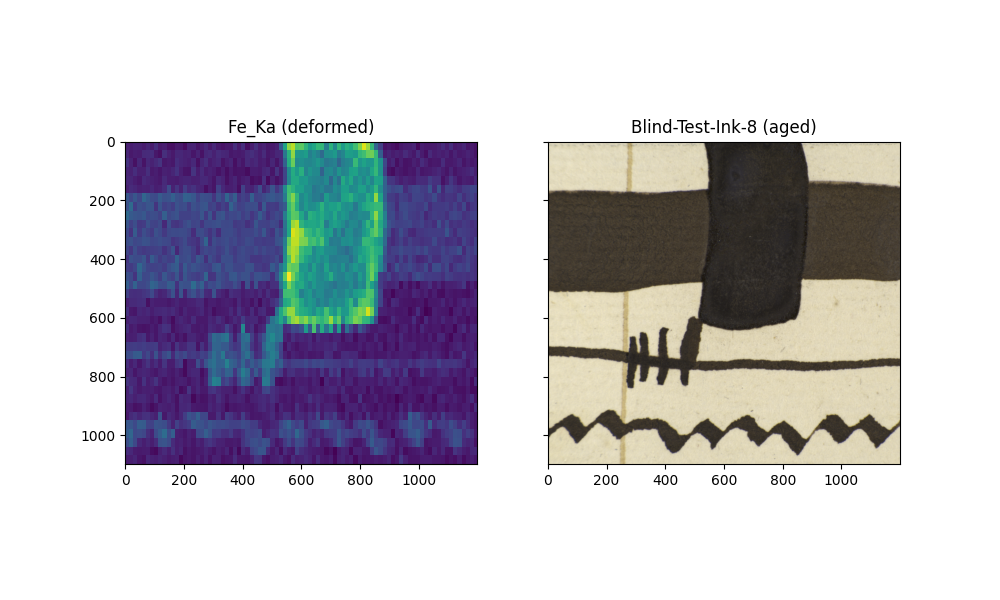

In [49]:
fig, [ax, ax1] = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=[10, 6])
ax.imshow(FeKa_map, extent=[0, w, h, 0])
ax1.imshow(img_vis)
ax.set_title('Fe_Ka (deformed)')
ax1.set_title('Blind-Test-Ink-8 (aged)');